<h1><center><font size="6">Modeling, Feature Selection and Notebook</font></center></h1>

# <a id='0'>Contents</a>

- <a href='#1'>Importing Packages</a>
- <a href='#2'>Base Model</a>  
    - <a href='#21'>Logistic Regression</a>
    - <a href='#22'>Random Forest Classifier</a>
    - <a href='#23'>Decision Tree Classifier</a>
    - <a href='#24'>K-Nearest Neighbors</a>
    - <a href='#25'>Gaussian Naive Bayes Classifier</a>
    - <a href='#26'>Linear Discriminant Analysis</a>
    - <a href='#27'>AdaBoost Classifier</a>
    - <a href='#28'>Gradient Boosting Classifier</a>
    - <a href='#29'>XGBoost Classifier</a>
- <a href='#3'>Model with Engineered Features</a>
    - <a href='#31'>Logistic Regression</a>
    - <a href='#32'>Random Forest Classifier</a>
    - <a href='#33'>Decision Tree Classifier</a>
    - <a href='#34'>K-Nearest Neighbors</a>
    - <a href='#35'>Gaussian Naive Bayes Classifier</a>
    - <a href='#36'>Linear Discriminant Analysis</a>
    - <a href='#37'>AdaBoost Classifier</a>
    - <a href='#38'>Gradient Boosting Classifier</a>
    - <a href='#39'>XGBoost Classifier</a>
- <a href='#4'>Feature Selection</a>
    - <a href='#41'>Decision Tree Feature Importance</a>
    - <a href='#42'>Random Forest Feature Importance</a>
    - <a href='#43'>XGBoost Feature Importance</a>
    - <a href='#44'>Recursive Feature Elimination with Cross-Validation</a>
- <a href='#5'>Discussion of Evaluation Metrics</a>


# <a id='1'>Importing Packages</a>

In [3]:
import numpy as np 
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools
from collections import Counter


from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc, mean_squared_error, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


%reload_ext autoreload
%autoreload 2

from utils import *

plt.style.use("fivethirtyeight")
sns.set_theme(style = "darkgrid", font = 'serif', context = 'poster')

import pickle

# <a id='2'>Baseline Model</a>

## Importing Pickles

In [4]:
pickle_in = open("../pickle/training_cleaned.pickle","rb")
train = pickle.load(pickle_in)
pickle_in = open("../pickle/validate_cleaned.pickle","rb")
validate = pickle.load(pickle_in)

In [5]:
train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1792.5,2,2,1,44,0,0,0,0,0,...,801.61,848.18,983.04,108.12,179.36,107.55,107.55,179.25,33.13,0
1,5736.0,2,3,1,46,0,0,0,0,0,...,147.95,143.22,30.19,84.00,174.09,35.85,143.22,30.19,943.32,0
2,3585.0,2,2,1,47,0,0,0,0,0,...,224.78,-14.20,-14.20,238.98,0.00,224.78,0.00,0.00,0.00,1
3,6094.5,2,2,1,29,0,0,0,0,0,...,2290.92,1559.65,1577.22,80.12,89.37,92.67,60.34,68.15,75.68,0
4,5377.5,2,1,2,33,0,0,0,0,0,...,1199.51,996.63,81.06,968.20,1172.83,1200.08,996.92,81.06,6075.32,0


In [6]:
validate.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1075.5,1,2,2,25,0,0,0,0,0,...,450.99,491.72,531.58,53.78,71.70,53.78,53.78,53.78,71.70,0
1,5377.5,2,1,2,26,0,0,0,0,0,...,3641.68,2787.02,2769.91,160.82,151.82,113.32,94.89,95.68,95.68,0
2,2509.5,2,3,1,32,0,0,0,0,0,...,2500.65,2513.48,2517.10,87.15,111.57,107.55,87.40,89.63,91.56,0
3,4660.5,1,3,2,49,0,0,0,0,0,...,605.79,402.81,248.94,57.72,64.82,251.45,0.97,251.34,158.03,0
4,1792.5,2,2,2,36,0,0,0,0,0,...,701.73,727.58,696.89,71.70,53.78,35.85,64.53,0.00,35.85,1


## Preparing Datasets for Modeling

### Separate into target and features

In [7]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]


### Standardize for Logistic Regression

In [8]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = X_train[['gender', 'education', 'marriage']]
dum_index = dum_feat.columns
tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
cont_feat = X_train.drop(['gender', 'education', 'marriage'], axis=1)
X_train_dum = cont_feat.join(tr_dum)
X_train_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,paid3,paid4,paid5,paid6,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3
0,1792.5,44,0,0,0,0,0,0,1633.97,1502.33,...,107.55,107.55,179.25,33.13,1,1,0,0,0,0
1,5736.0,46,0,0,0,0,0,0,892.81,83.82,...,35.85,143.22,30.19,943.32,1,0,1,0,0,0
2,3585.0,47,0,0,0,0,0,0,238.98,238.98,...,224.78,0.00,0.00,0.00,1,1,0,0,0,0
3,6094.5,29,0,0,0,0,0,0,2835.41,2243.31,...,92.67,60.34,68.15,75.68,1,1,0,0,0,0
4,5377.5,33,0,0,0,0,0,0,874.49,962.47,...,1200.08,996.92,81.06,6075.32,1,0,0,0,1,0


In [9]:
dum_feat2 = X_validate[['gender', 'education', 'marriage']]
dum_index2 = dum_feat2.columns
val_dum = pd.get_dummies(data=dum_feat2, columns=dum_index2, drop_first=True, prefix=['sex', 'edu', 'mar'])
cont_feat2 = X_validate.drop(['gender', 'education', 'marriage'], axis=1)
X_validate_dum = cont_feat2.join(val_dum)
X_validate_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,paid3,paid4,paid5,paid6,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3
0,1075.5,25,0,0,0,0,0,0,317.77,360.72,...,53.78,53.78,53.78,71.70,0,1,0,0,1,0
1,5377.5,26,0,0,0,0,0,0,4901.99,4504.59,...,113.32,94.89,95.68,95.68,1,0,0,0,1,0
2,2509.5,32,0,0,0,0,0,0,2513.87,2476.52,...,107.55,87.40,89.63,91.56,1,0,1,0,0,0
3,4660.5,49,0,0,0,0,0,0,741.31,679.57,...,251.45,0.97,251.34,158.03,0,0,1,0,1,0
4,1792.5,36,0,0,0,0,0,2,3378.07,1707.71,...,35.85,64.53,0.00,35.85,1,1,0,0,1,0


In [10]:
scaler = StandardScaler().fit(X_train_dum)
X_tr_dum = scaler.transform(X_train_dum)
X_val_dum = scaler.transform(X_validate_dum)

### Standardize for all other classification models

In [11]:
scaler2 = StandardScaler().fit(X_train)
X_tr = scaler2.transform(X_train)
X_val = scaler2.transform(X_validate)

## <a id='21'>Logistic Regression</a>

Training Accuracy:  0.8210952380952381
Validation Accuracy:  0.8161666666666667
Training F1 Score:  0.46213314244810305
Validation F1 Score:  0.4358056265984655
Training AUC Score:  0.7629019991993446
Validation AUC Score:  0.7617278820987414
Training Recall Score:  0.34664948453608246
Validation Recall Score:  0.32444782939832445
Training Precision Score:  0.6930012881064834
Validation Precision Score:  0.6635514018691588
Training Average Precision Score:  0.5366287535445587
Validation Average Precision Score:  0.5130619582048979

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.35      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.68     21000
weighted avg       0.81      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           

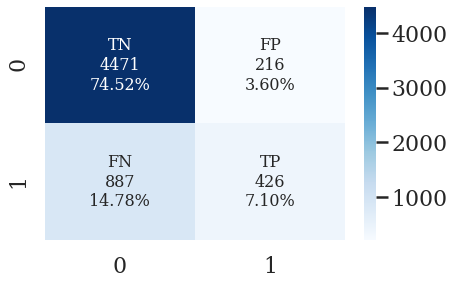

In [12]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr_dum, y_tr)
y_pred_log_tr = logreg.predict(X_tr_dum)
y_pred_log_val = logreg.predict(X_val_dum)
get_metrics(X_tr_dum, y_tr, X_val_dum, y_val, y_pred_log_tr, y_pred_log_val, logreg)

## <a id='22'>Random Forest Classifier</a>

Training Accuracy:  0.9994285714285714
Validation Accuracy:  0.8136666666666666
Training F1 Score:  0.9987113402061856
Validation F1 Score:  0.4530332681017612
Training AUC Score:  0.9999970301322259
Validation AUC Score:  0.7575522450244401
Training Recall Score:  0.9987113402061856
Validation Recall Score:  0.3526275704493526
Training Precision Score:  0.9987113402061856
Validation Precision Score:  0.6333789329685362
Training Average Precision Score:  0.9999892498479974
Validation Average Precision Score:  0.5110392621643958

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

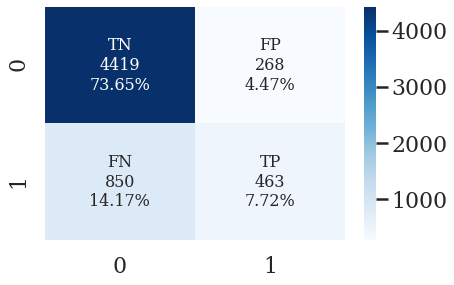

In [13]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

## <a id='13'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7251666666666666
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3830901608679387
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6049392666367784
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.38994668697638996
Training Precision Score:  1.0
Validation Precision Score:  0.3764705882352941
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.2805445492347045

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83     

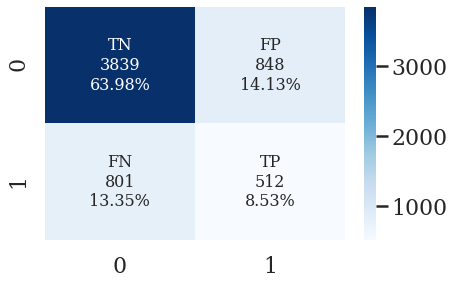

In [14]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

## <a id='14'>K-Nearest Neighbors</a>

Training Accuracy:  0.8432380952380952
Validation Accuracy:  0.795
Training F1 Score:  0.5743470390483579
Validation F1 Score:  0.4409090909090909
Training AUC Score:  0.8808609289241783
Validation AUC Score:  0.7034312956824559
Training Recall Score:  0.47701890034364264
Validation Recall Score:  0.3693830921553694
Training Precision Score:  0.7215724496426251
Validation Precision Score:  0.5467869222096956
Training Average Precision Score:  0.6407308197014812
Validation Average Precision Score:  0.4196984439920553

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.48      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84   

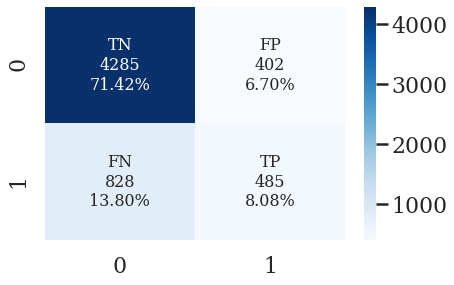

In [15]:
knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

## <a id='15'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.7695238095238095
Validation Accuracy:  0.7656666666666667
Training F1 Score:  0.520126908586159
Validation F1 Score:  0.5097629009762901
Training AUC Score:  0.748431949238284
Validation AUC Score:  0.745857065068408
Training Recall Score:  0.5633591065292096
Validation Recall Score:  0.5567402894135567
Training Precision Score:  0.4830570902394107
Validation Precision Score:  0.470096463022508
Training Average Precision Score:  0.5028263739501528
Validation Average Precision Score:  0.4834112012715249

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     16344
           1       0.48      0.56      0.52      4656

    accuracy                           0.77     21000
   macro avg       0.68      0.70      0.68     21000
weighted avg       0.78      0.77      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0      

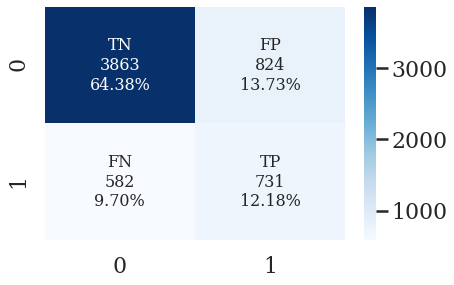

In [16]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

## <a id='17'>Linear Discriminant Analysis</a>

Training Accuracy:  0.8215714285714286
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.4799444829979181
Validation F1 Score:  0.4643564356435644
Training AUC Score:  0.7601188914287829
Validation AUC Score:  0.757567519565631
Training Recall Score:  0.3713487972508591
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.6783052177324441
Validation Precision Score:  0.6633663366336634
Training Average Precision Score:  0.5343332810122179
Validation Average Precision Score:  0.5117838215147247

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.81      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

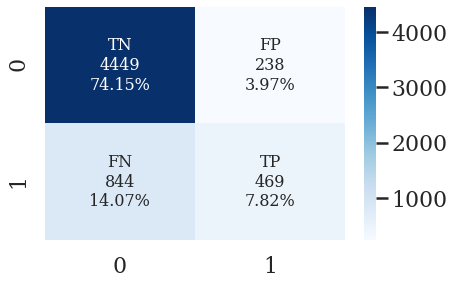

In [17]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_lda_tr, y_pred_lda_val, lda)

## <a id='16'>AdaBoost Classifier</a>

Training Accuracy:  0.819952380952381
Validation Accuracy:  0.8153333333333334
Training F1 Score:  0.4511540136449411
Validation F1 Score:  0.4235171696149844
Training AUC Score:  0.7873281037904132
Validation AUC Score:  0.7762876885085563
Training Recall Score:  0.3337628865979381
Validation Recall Score:  0.30997715156131
Training Precision Score:  0.6959247648902821
Validation Precision Score:  0.6683087027914614
Training Average Precision Score:  0.5585736608944247
Validation Average Precision Score:  0.5247647859929081

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.70      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0     

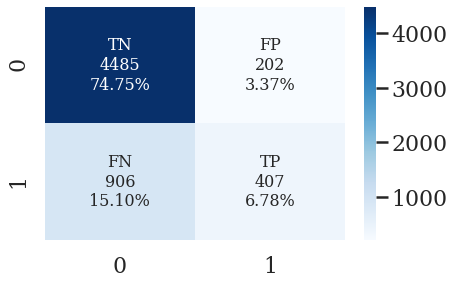

In [18]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

## <a id='18'> Gradient Boosting Classifier</a>

Training Accuracy:  0.8287142857142857
Validation Accuracy:  0.8198333333333333
Training F1 Score:  0.5039304923458833
Validation F1 Score:  0.4645864289252105
Training AUC Score:  0.8093206777017491
Validation AUC Score:  0.781361598600982
Training Recall Score:  0.39239690721649484
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7040462427745665
Validation Precision Score:  0.6643059490084986
Training Average Precision Score:  0.6080316518725907
Validation Average Precision Score:  0.5480601119052119

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.70      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

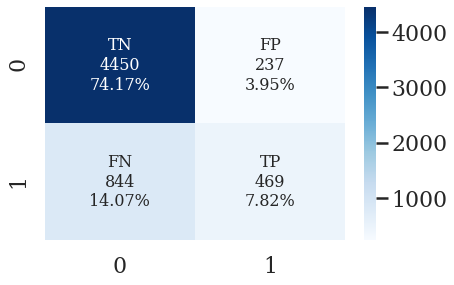

In [19]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbc_tr, y_pred_gbc_val, gbc)

## <a id='19'>XGBoost Classifier</a>

[19:41:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.891095238095238
Validation Accuracy:  0.8143333333333334
Training F1 Score:  0.6986427724337858
Validation F1 Score:  0.46493756003842457
Training AUC Score:  0.9490677926723217
Validation AUC Score:  0.7630322304193788
Training Recall Score:  0.569372852233677
Validation Recall Score:  0.3686214775323686
Training Precision Score:  0.9038527105352882
Validation Precision Score:  0.6293888166449935
Training Average Precision Score:  0.8672532450149335
Validation Average Precision Score:  0.5220846141707834

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16344
           1 

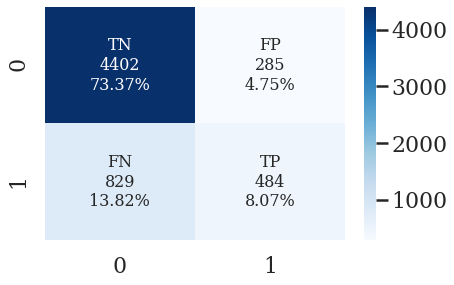

In [20]:
xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgb_tr, y_pred_xgb_val, xgb)

## Evaluation Metrics Summary

In [21]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val), 
                     accuracy(y_val, y_pred_rfc_val), 
                     accuracy(y_val, y_pred_dtc_val), 
                     accuracy(y_val, y_pred_knn_val), 
                     accuracy(y_val, y_pred_gnb_val), 
                     accuracy(y_val, y_pred_lda_val), 
                     accuracy(y_val, y_pred_abc_val), 
                     accuracy(y_val, y_pred_gbc_val),
                     accuracy(y_val, y_pred_xgb_val)],
        'F1 Score': [f1(y_val, y_pred_log_val), 
                     f1(y_val, y_pred_rfc_val), 
                     f1(y_val, y_pred_dtc_val), 
                     f1(y_val, y_pred_knn_val), 
                     f1(y_val, y_pred_gnb_val), 
                     f1(y_val, y_pred_lda_val), 
                     f1(y_val, y_pred_abc_val), 
                     f1(y_val, y_pred_gbc_val),
                     f1(y_val, y_pred_xgb_val)],
        'ROC AUC': [auc(X_val_dum, y_val, logreg),
                      auc(X_val, y_val, rfc),
                      auc(X_val, y_val, dtc),
                      auc(X_val, y_val, knn),
                      auc(X_val, y_val, gnb),
                      auc(X_val, y_val, lda),
                      auc(X_val, y_val, abc),
                      auc(X_val, y_val, gbc),
                      auc(X_val, y_val, xgb)],
        'Recall': [recall(y_val, y_pred_log_val), 
                   recall(y_val, y_pred_rfc_val), 
                   recall(y_val, y_pred_dtc_val), 
                   recall(y_val, y_pred_knn_val), 
                   recall(y_val, y_pred_gnb_val), 
                   recall(y_val, y_pred_lda_val), 
                   recall(y_val, y_pred_abc_val),
                   recall(y_val, y_pred_gbc_val),
                   recall(y_val, y_pred_xgb_val)],
        'Precision': [precision(y_val, y_pred_log_val), 
                      precision(y_val, y_pred_rfc_val), 
                      precision(y_val, y_pred_dtc_val), 
                      precision(y_val, y_pred_knn_val), 
                      precision(y_val, y_pred_gnb_val),
                      precision(y_val, y_pred_lda_val), 
                      precision(y_val, y_pred_abc_val),
                      precision(y_val, y_pred_gbc_val),
                      precision(y_val, y_pred_xgb_val)],
        'PR AUC': [aps(X_val_dum, y_val, logreg),
                   aps(X_val, y_val, rfc),
                   aps(X_val, y_val, dtc),
                   aps(X_val, y_val, knn),
                   aps(X_val, y_val, gnb),
                   aps(X_val, y_val, lda),
                   aps(X_val, y_val, abc),
                   aps(X_val, y_val, gbc),
                   aps(X_val, y_val, xgb)]}
baseline = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'Decision Tree Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Linear Discriminant Analysis', 
                                          'AdaBoost Classifier', 
                                          'Gradient Boosting Classifier',
                                          'XGBoost Classifier'])

In [22]:
baseline

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression,0.816167,0.435806,0.761728,0.324448,0.663551,0.513062
Random Forest Classifier,0.813667,0.453033,0.757552,0.352628,0.633379,0.511039
Decision Tree Classifier,0.725167,0.383090,0.604939,0.389947,0.376471,0.280545
K-Nearest Neighbors,0.795000,0.440909,0.703431,0.369383,0.546787,0.419698
Gaussian Naive Bayes,0.765667,0.509763,0.745857,0.556740,0.470096,0.483411
Linear Discriminant Analysis,0.819667,0.464356,0.757568,0.357197,0.663366,0.511784
AdaBoost Classifier,0.815333,0.423517,0.776288,0.309977,0.668309,0.524765
Gradient Boosting Classifier,0.819833,0.464586,0.781362,0.357197,0.664306,0.548060
XGBoost Classifier,0.814333,0.464938,0.763032,0.368621,0.629389,0.522085


# <a id='2'>Modeling with Engineered Features</a>

## Importing Pickles

In [23]:
pickle_in = open("../pickle/training_features.pickle","rb")
train2 = pickle.load(pickle_in)
pickle_in = open("../pickle/validate_features.pickle","rb")
validate2 = pickle.load(pickle_in)

In [24]:
train2.columns

Index(['limit', 'gender', 'education', 'marriage', 'age', 'behind1', 'behind2',
       'behind3', 'behind4', 'behind5', 'behind6', 'billed1', 'billed2',
       'billed3', 'billed4', 'billed5', 'billed6', 'paid1', 'paid2', 'paid3',
       'paid4', 'paid5', 'paid6', 'default', 'age_bin', 'gen-mar', 'gen-age',
       'avail6', 'avail5', 'avail4', 'avail3', 'avail2', 'avail1', 'avg_av',
       'pperb1', 'pperb2', 'pperb3', 'pperb4', 'pperb5'],
      dtype='object')

In [25]:
validate2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1075.5,1,2,2,25,0,0,0,0,0,...,0.580669,0.613966,0.664603,0.704537,0.602052,0.149091,0.172696,0.119249,0.109371,0.101170
1,5377.5,2,1,2,26,0,0,0,0,0,...,0.322793,0.222107,0.162326,0.088426,0.293714,0.035701,0.036293,0.031118,0.034047,0.034543
2,2509.5,2,3,1,32,0,0,0,0,0,...,0.003527,0.021000,0.013142,-0.001741,0.005219,0.035191,0.045413,0.043009,0.034773,0.035608
3,4660.5,1,3,2,49,0,0,0,0,0,...,0.870016,0.875599,0.854185,0.840938,0.883482,0.084936,0.111803,0.415078,0.002408,1.009641
4,1792.5,2,2,2,36,0,0,0,0,0,...,0.608519,0.152781,0.047303,-0.884558,0.188227,0.041986,0.035413,0.051088,0.088691,0.000000


## Preparing Datasets for Modeling

In [58]:
X_train2 = train2.drop(["default"], axis=1)
y_tr = train2["default"]
X_validate2 = validate2.drop(["default"], axis=1)
y_val = validate2["default"]

In [59]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = X_train2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index = dum_feat.columns
tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat = X_train2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_train2_dum = cont_feat.join(tr_dum)
X_train2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1792.5,44,0,0,0,0,0,0,1633.97,1502.33,...,0,0,1,0,1,0,0,0,1,0
1,5736.0,46,0,0,0,0,0,0,892.81,83.82,...,0,0,1,0,1,0,0,0,1,0
2,3585.0,47,0,0,0,0,0,0,238.98,238.98,...,0,0,1,0,1,0,0,0,1,0
3,6094.5,29,0,0,0,0,0,0,2835.41,2243.31,...,0,0,0,0,1,0,0,1,0,0
4,5377.5,33,0,0,0,0,0,0,874.49,962.47,...,1,0,1,0,0,1,0,0,1,0


In [29]:
dum_feat2 = X_validate2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index2 = dum_feat2.columns
val_dum = pd.get_dummies(data=dum_feat2, columns=dum_index2, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat2 = X_validate2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_validate2_dum = cont_feat2.join(val_dum)
X_validate2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1075.5,25,0,0,0,0,0,0,317.77,360.72,...,1,0,0,0,1,0,0,0,0,0
1,5377.5,26,0,0,0,0,0,0,4901.99,4504.59,...,1,0,0,0,0,1,0,1,0,0
2,2509.5,32,0,0,0,0,0,0,2513.87,2476.52,...,0,0,1,0,1,0,0,0,1,0
3,4660.5,49,0,0,0,0,0,0,741.31,679.57,...,1,0,1,0,1,0,0,1,0,0
4,1792.5,36,0,0,0,0,0,2,3378.07,1707.71,...,1,0,1,0,0,1,0,0,1,0


In [30]:
scaler = StandardScaler().fit(X_train2_dum)
X_tr2_dum = scaler.transform(X_train2_dum)
X_val2_dum = scaler.transform(X_validate2_dum)

In [31]:
scaler2 = StandardScaler().fit(X_train2)
X_tr2 = scaler2.transform(X_train2)
X_val2 = scaler2.transform(X_validate2)

## <a id='31'>Logistic Regression</a>

Training Accuracy:  0.8207142857142857
Validation Accuracy:  0.817
Training F1 Score:  0.4605244304341596
Validation F1 Score:  0.43576567317574516
Training AUC Score:  0.7645280412287032
Validation AUC Score:  0.7560719144898685
Training Recall Score:  0.34514604810996563
Validation Recall Score:  0.32292460015232294
Training Precision Score:  0.6917778734395179
Validation Precision Score:  0.669826224328594
Training Average Precision Score:  0.5376778099138453
Validation Average Precision Score:  0.5092044581353998

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.35      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83  

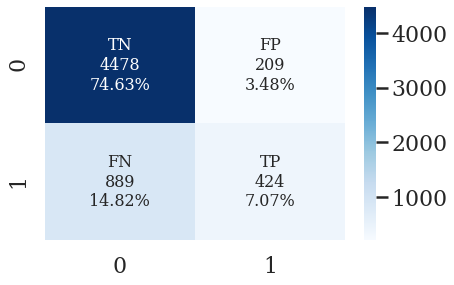

In [82]:
logreg2 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr2_dum, y_tr)
y_pred_log_tr2 = logreg2.predict(X_tr2_dum)
y_pred_log_val2 = logreg2.predict(X_val2_dum)
get_metrics(X_tr2_dum, y_tr, X_val2_dum, y_val, y_pred_log_tr2, y_pred_log_val2, logreg2)

## <a id='32'>Random Forest Classifier</a>

Training Accuracy:  0.9993809523809524
Validation Accuracy:  0.8121666666666667
Training F1 Score:  0.9986029016657711
Validation F1 Score:  0.45158150851581513
Training AUC Score:  0.9999976871826184
Validation AUC Score:  0.7550884940293605
Training Recall Score:  0.997852233676976
Validation Recall Score:  0.3533891850723534
Training Precision Score:  0.99935469993547
Validation Precision Score:  0.6253369272237197
Training Average Precision Score:  0.9999915997613857
Validation Average Precision Score:  0.5158952022184671

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

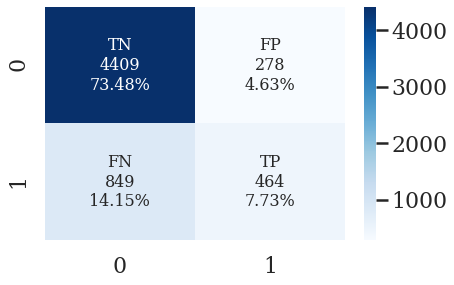

In [33]:
rfc2 = RandomForestClassifier().fit(X_tr2, y_tr)
y_pred_rfc_tr2 = rfc2.predict(X_tr2)
y_pred_rfc_val2 = rfc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_rfc_tr2, y_pred_rfc_val2, rfc2)

## <a id='33'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7205
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3912885662431942
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6087990944472005
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.4105102817974105
Training Precision Score:  1.0
Validation Precision Score:  0.3737864077669903
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.28244316358446897

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.81      0

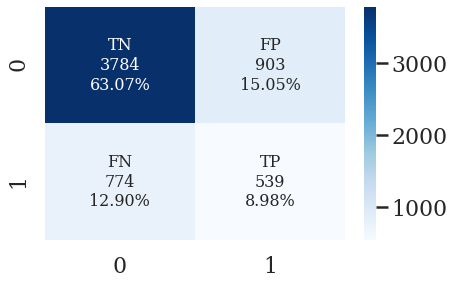

In [34]:
dtc2 = DecisionTreeClassifier().fit(X_tr2, y_tr)
y_pred_dtc_tr2 = dtc2.predict(X_tr2)
y_pred_dtc_val2 = dtc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_dtc_tr2, y_pred_dtc_val2, dtc2)

## <a id='34'>K-Nearest Neighbors</a>

Training Accuracy:  0.842047619047619
Validation Accuracy:  0.7923333333333333
Training F1 Score:  0.5690528777445758
Validation F1 Score:  0.4294871794871795
Training AUC Score:  0.8815147006352257
Validation AUC Score:  0.7008639540489802
Training Recall Score:  0.47036082474226804
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7201578428148635
Validation Precision Score:  0.5384615384615384
Training Average Precision Score:  0.6365646721618267
Validation Average Precision Score:  0.40696863317897186

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.47      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

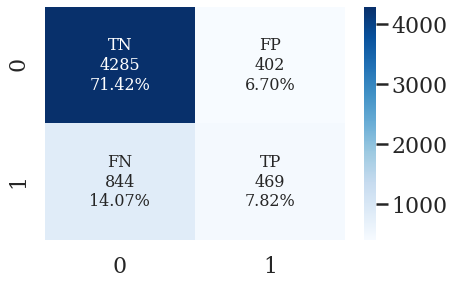

In [35]:
knn2 = KNeighborsClassifier().fit(X_tr2, y_tr)
y_pred_knn_tr2 = knn2.predict(X_tr2)
y_pred_knn_val2 = knn2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_knn_tr2, y_pred_knn_val2, knn2)

## <a id='35'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.27204761904761904
Validation Accuracy:  0.282
Training F1 Score:  0.37113826154922047
Validation F1 Score:  0.3752900232018561
Training AUC Score:  0.7288273855554883
Validation AUC Score:  0.728547272511302
Training Recall Score:  0.9688573883161512
Validation Recall Score:  0.9855293221629855
Training Precision Score:  0.2295323869129395
Validation Precision Score:  0.23177503134515492
Training Average Precision Score:  0.48404241797179354
Validation Average Precision Score:  0.47226198950996207

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.07      0.14     16344
           1       0.23      0.97      0.37      4656

    accuracy                           0.27     21000
   macro avg       0.56      0.52      0.25     21000
weighted avg       0.75      0.27      0.19     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.95

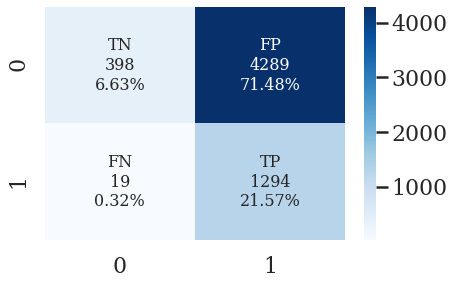

In [36]:
gnb2 = GaussianNB().fit(X_tr2, y_tr)
y_pred_gnb_tr2 = gnb2.predict(X_tr2)
y_pred_gnb_val2 = gnb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gnb_tr2, y_pred_gnb_val2, gnb2)

## <a id='36'>Linear Discriminant Analysis Classifier</a>

Training Accuracy:  0.8211904761904761
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.47984485385787495
Validation F1 Score:  0.4632936507936508
Training AUC Score:  0.7603054937402546
Validation AUC Score:  0.7512462969393557
Training Recall Score:  0.37199312714776633
Validation Recall Score:  0.3556740289413557
Training Precision Score:  0.6757705813499805
Validation Precision Score:  0.6642958748221907
Training Average Precision Score:  0.5346638614970192
Validation Average Precision Score:  0.5075303220859997

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

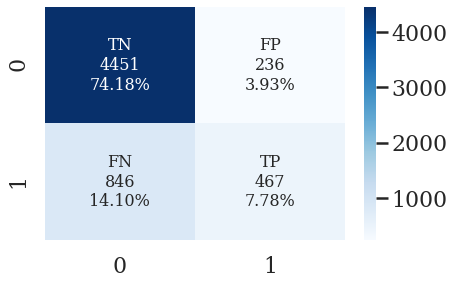

In [37]:
lda2 = LinearDiscriminantAnalysis().fit(X_tr2, y_tr)
y_pred_lda_tr2 = lda2.predict(X_tr2)
y_pred_lda_val2 = lda2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_lda_tr2, y_pred_lda_val2, lda2)

## <a id='37'>AdaBoost Classifier</a>

Training Accuracy:  0.8196666666666667
Validation Accuracy:  0.8168333333333333
Training F1 Score:  0.4501234209379991
Validation F1 Score:  0.4314536989136058
Training AUC Score:  0.7930206898335275
Validation AUC Score:  0.7744014451665908
Training Recall Score:  0.3329037800687285
Validation Recall Score:  0.3175932977913176
Training Precision Score:  0.6947557149260422
Validation Precision Score:  0.6725806451612903
Training Average Precision Score:  0.5631313508801818
Validation Average Precision Score:  0.5247603776689956

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.69      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

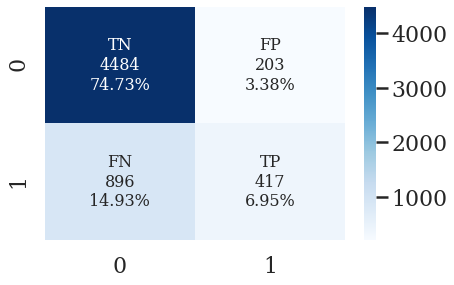

In [38]:
abc2 = AdaBoostClassifier().fit(X_tr2, y_tr)
y_pred_abc_tr2 = abc2.predict(X_tr2)
y_pred_abc_val2 = abc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_abc_tr2, y_pred_abc_val2, abc2)

## <a id='38'>Gradient Boosting Classifier</a>

Training Accuracy:  0.8292380952380952
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.5035991140642303
Validation F1 Score:  0.4638255698711596
Training AUC Score:  0.8138050137780839
Validation AUC Score:  0.7836401051603412
Training Recall Score:  0.3906786941580756
Validation Recall Score:  0.3564356435643564
Training Precision Score:  0.7083333333333334
Validation Precision Score:  0.6638297872340425
Training Average Precision Score:  0.6123069088262323
Validation Average Precision Score:  0.5473861393499133

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

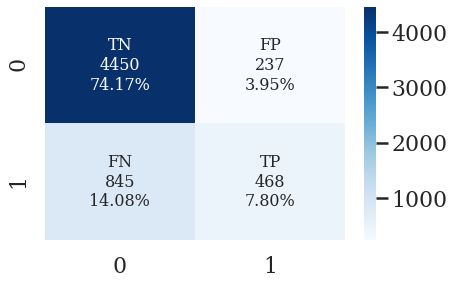

In [39]:
gbc2 = GradientBoostingClassifier().fit(X_tr2, y_tr)
y_pred_gbc_tr2 = gbc2.predict(X_tr2)
y_pred_gbc_val2 = gbc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gbc_tr2, y_pred_gbc_val2, gbc2)

## <a id='39'>XGBoost Classifier</a>

[19:49:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.901
Validation Accuracy:  0.8143333333333334
Training F1 Score:  0.7319840144385716
Validation F1 Score:  0.4623552123552123
Training AUC Score:  0.9594788546991404
Validation AUC Score:  0.7635696830256461
Training Recall Score:  0.6097508591065293
Validation Recall Score:  0.3648134044173648
Training Precision Score:  0.9155111254434054
Validation Precision Score:  0.6310935441370223
Training Average Precision Score:  0.8914732846487116
Validation Average Precision Score:  0.5158710293226549

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     16344
           1       0.92  

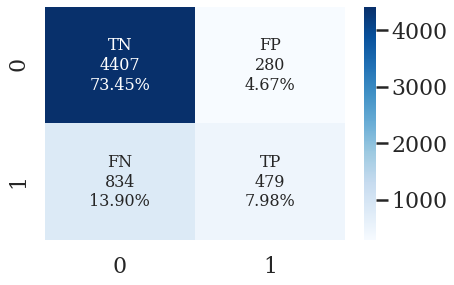

In [40]:
xgb2 = XGBClassifier().fit(X_tr2, y_tr)
y_pred_xgb_tr2 = xgb2.predict(X_tr2)
y_pred_xgb_val2 = xgb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_xgb_tr2, y_pred_xgb_val2, xgb2)

In [87]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val2), 
                     accuracy(y_val, y_pred_rfc_val2), 
                     accuracy(y_val, y_pred_dtc_val2), 
                     accuracy(y_val, y_pred_knn_val2), 
                     accuracy(y_val, y_pred_gnb_val2), 
                     accuracy(y_val, y_pred_lda_val2), 
                     accuracy(y_val, y_pred_abc_val2), 
                     accuracy(y_val, y_pred_gbc_val2),
                     accuracy(y_val, y_pred_xgb_val2)],
        'F1 Score': [f1(y_val, y_pred_log_val2), 
                     f1(y_val, y_pred_rfc_val2), 
                     f1(y_val, y_pred_dtc_val2), 
                     f1(y_val, y_pred_knn_val2), 
                     f1(y_val, y_pred_gnb_val2), 
                     f1(y_val, y_pred_lda_val2), 
                     f1(y_val, y_pred_abc_val2), 
                     f1(y_val, y_pred_gbc_val2),
                     f1(y_val, y_pred_xgb_val2)],
        'ROC AUC': [auc(X_val2_dum, y_val, logreg2),
                    auc(X_val2, y_val, rfc2),
                    auc(X_val2, y_val, dtc2),
                    auc(X_val2, y_val, knn2),
                    auc(X_val2, y_val, gnb2),
                    auc(X_val2, y_val, lda2),
                    auc(X_val2, y_val, abc2),
                    auc(X_val2, y_val, gbc2),
                    auc(X_val2, y_val, xgb2)],
        'Recall': [recall(y_val, y_pred_log_val2), 
                   recall(y_val, y_pred_rfc_val2), 
                   recall(y_val, y_pred_dtc_val2), 
                   recall(y_val, y_pred_knn_val2), 
                   recall(y_val, y_pred_gnb_val2), 
                   recall(y_val, y_pred_lda_val2), 
                   recall(y_val, y_pred_abc_val2),
                   recall(y_val, y_pred_gbc_val2),
                   recall(y_val, y_pred_xgb_val2)],
        'Precision': [precision(y_val, y_pred_log_val2), 
                      precision(y_val, y_pred_rfc_val2), 
                      precision(y_val, y_pred_dtc_val2), 
                      precision(y_val, y_pred_knn_val2), 
                      precision(y_val, y_pred_gnb_val2),
                      precision(y_val, y_pred_lda_val2), 
                      precision(y_val, y_pred_abc_val2),
                      precision(y_val, y_pred_gbc_val2),
                      precision(y_val, y_pred_xgb_val2)],
        'PR AUC': [aps(X_val2_dum, y_val, logreg2),
                   aps(X_val2, y_val, rfc2),
                   aps(X_val2, y_val, dtc2),
                   aps(X_val2, y_val, knn2),
                   aps(X_val2, y_val, gnb2),
                   aps(X_val2, y_val, lda2),
                   aps(X_val2, y_val, abc2),
                   aps(X_val2, y_val, gbc2),
                   aps(X_val2, y_val, xgb2)]}
features_model = pd.DataFrame(data=data, index = ['Logistic Regression 2', 
                                          'Random Forest Classifier 2', 
                                          'Decision Tree Classifier 2', 
                                          'K-Nearest Neighbors 2', 
                                          'Gaussian Naive Bayes 2', 
                                          'Linear Discriminant Analysis 2', 
                                          'AdaBoost Classifier 2', 
                                          'Gradient Boosting Classifier 2',
                                          'XGBoost Classifier 2'])

In [88]:
features_model

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression 2,0.817000,0.435766,0.756072,0.322925,0.669826,0.509204
Random Forest Classifier 2,0.812167,0.451582,0.755088,0.353389,0.625337,0.515895
Decision Tree Classifier 2,0.720500,0.391289,0.608799,0.410510,0.373786,0.282443
K-Nearest Neighbors 2,0.792333,0.429487,0.700864,0.357197,0.538462,0.406969
Gaussian Naive Bayes 2,0.282000,0.375290,0.728547,0.985529,0.231775,0.472262
Linear Discriminant Analysis 2,0.819667,0.463294,0.751246,0.355674,0.664296,0.507530
AdaBoost Classifier 2,0.816833,0.431454,0.774401,0.317593,0.672581,0.524760
Gradient Boosting Classifier 2,0.819667,0.463826,0.783640,0.356436,0.663830,0.547386
XGBoost Classifier 2,0.814333,0.462355,0.763570,0.364813,0.631094,0.515871


# <a id='4'> Feature Selection</a>

## <a id='41'>Decision Tree (CART) Feature Importance</a>

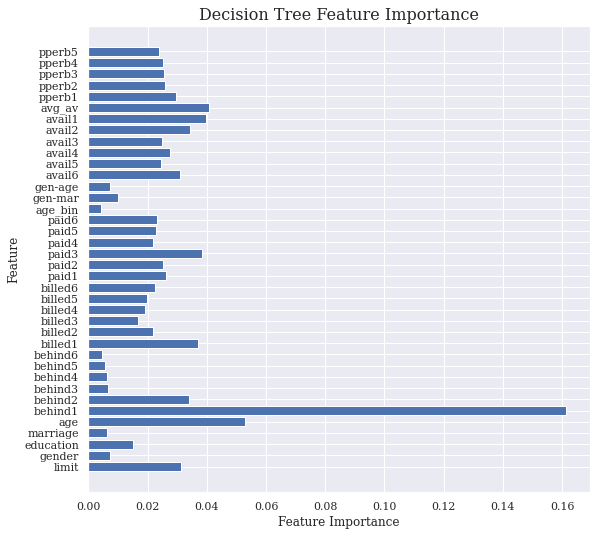

In [55]:
# sns.set_theme(style="darkgrid", font='serif', context='notebook')
# plot_feature_importances(X_train2, dtc2)
# plt.title("Decision Tree Feature Importance", size=16)
# plt.savefig('../images/dtc2_feature_importance.png')

## <a id='42'>Random Forest Feature Importance</a>

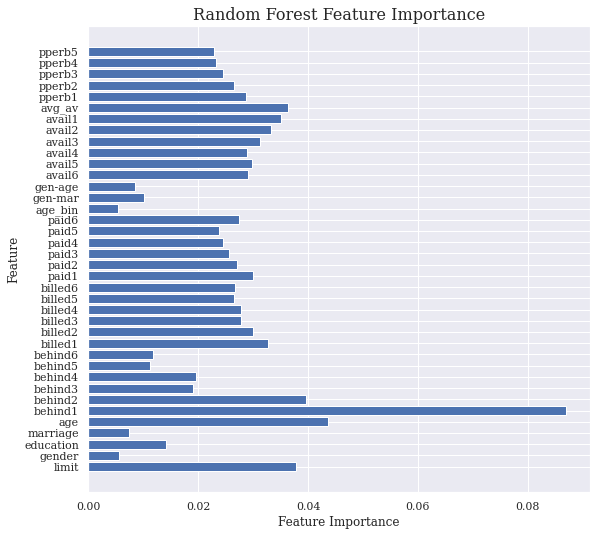

In [56]:
# plot_feature_importances(X_train2, rfc2)
# plt.title("Random Forest Feature Importance", size=16)
# plt.savefig('../images/rf_feature_importance.png')

## <a id='43'>XGBoost Feature Importance</a>

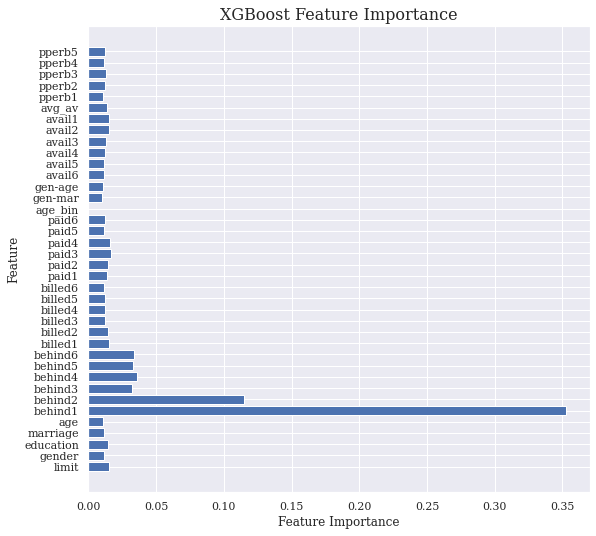

In [57]:
# plot_feature_importances(X_train2, xgb2)
# plt.title("XGBoost Feature Importance", size=16)
# plt.savefig('../images/xgb_feature_importance.png')

## <a id='39'>Recursive Feature Elimination with Cross-Validation</a>

Feature Ranking For Non-Discretised: [ 3 28 20 27 19  1 18  7 13 21  2 15 14  9 22 33 10  6  1 35 23 32 17 26
  8 37 11 12 29 16  4  5 34 30 25 24 36 31]
Optimal number of features : 2


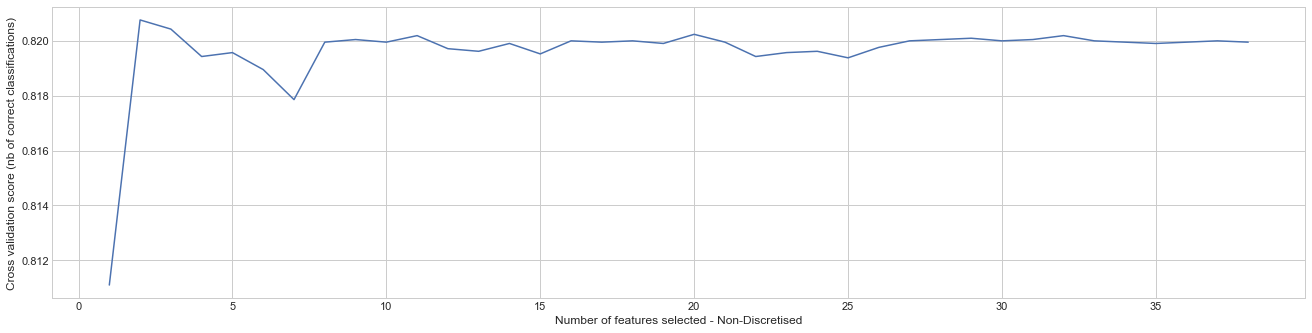

In [58]:
# from sklearn.feature_selection import RFECV
# rfe = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1).fit(X_tr2, y_tr)
# print("Feature Ranking For Non-Discretised: %s" % rfe.ranking_)
# print("Optimal number of features : %d" % rfe.n_features_)

# plt.style.use('seaborn-whitegrid')
# plt.figure(figsize=(20,5)) 
# plt.xlabel("Number of features selected - Non-Discretised")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_);



In [59]:
# selected = X_train2.columns[rfe.support_]
# print(selected)

Index(['behind1', 'paid2'], dtype='object')


In [ ]:
train2 = pd.read_csv("../data/train_feature.csv")
validate2 = pd.read_csv("../data/validate_feature.csv")
train3 = train2.drop(["gender","education", "marriage", "behind4", "behind5", "behind6", "gen-age", "gen-mar", "age_bin", "pperb1", "pperb2", "pperb3", "pperb4", "pperb5"], axis=1)
validate3 = validate2.drop(["gender","education", "marriage", "behind4", "behind5", "behind6", "gen-age", "gen-mar", "age_bin", "pperb1", "pperb2", "pperb3", "pperb4", "pperb5"], axis=1)

In [ ]:
train3.to_csv("../data/train_model.csv")
validate3.to_csv("../data/validate_model.csv")

# <a id='5'>Discussion of Evaluation Metrics</a>

In [94]:
metrics = pd.concat([baseline, features_model])

In [95]:
metrics

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression,0.816167,0.435806,0.761728,0.324448,0.663551,0.513062
Random Forest Classifier,0.813667,0.453033,0.757552,0.352628,0.633379,0.511039
Decision Tree Classifier,0.725167,0.383090,0.604939,0.389947,0.376471,0.280545
K-Nearest Neighbors,0.795000,0.440909,0.703431,0.369383,0.546787,0.419698
Gaussian Naive Bayes,0.765667,0.509763,0.745857,0.556740,0.470096,0.483411
Linear Discriminant Analysis,0.819667,0.464356,0.757568,0.357197,0.663366,0.511784
AdaBoost Classifier,0.815333,0.423517,0.776288,0.309977,0.668309,0.524765
Gradient Boosting Classifier,0.819833,0.464586,0.781362,0.357197,0.664306,0.548060
XGBoost Classifier,0.814333,0.464938,0.763032,0.368621,0.629389,0.522085
Logistic Regression 2,0.817000,0.435766,0.756072,0.322925,0.669826,0.509204


# New Baseline Model

In [96]:
pickle_in = open("../pickle/training_model.pickle","rb")
train3 = pickle.load(pickle_in)
pickle_in = open("../pickle/validate_model.pickle","rb")
validate3 = pickle.load(pickle_in)

In [97]:
X_train3 = train3.drop(["default"], axis=1)
y_tr = train3["default"]
X_validate3 = validate3.drop(["default"], axis=1)
y_val = validate3["default"]

In [99]:
scaler3 = StandardScaler().fit(X_train3)
X_tr3 = scaler3.transform(X_train3)
X_val3 = scaler3.transform(X_validate3)

Training Accuracy:  0.8199047619047619
Validation Accuracy:  0.8168333333333333
Training F1 Score:  0.4569213095921884
Validation F1 Score:  0.4395716471188169
Training AUC Score:  0.7554399304556838
Validation AUC Score:  0.7490975427325601
Training Recall Score:  0.34170962199312716
Validation Recall Score:  0.32825590251332826
Training Precision Score:  0.6893414211438474
Validation Precision Score:  0.6651234567901234
Training Average Precision Score:  0.5273949412376221
Validation Average Precision Score:  0.49990660326747194

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           

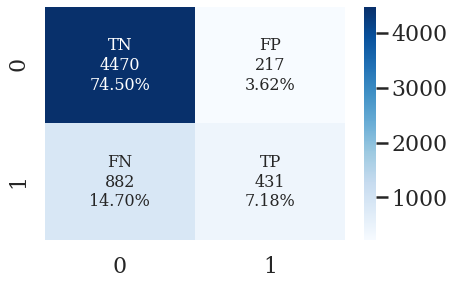

In [100]:
logreg3 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr3, y_tr)
y_pred_log_tr3 = logreg3.predict(X_tr3)
y_pred_log_val3 = logreg3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_log_tr3, y_pred_log_val3, logreg3)

Training Accuracy:  0.9981428571428571
Validation Accuracy:  0.81
Training F1 Score:  0.9958069024836039
Validation F1 Score:  0.4444444444444445
Training AUC Score:  0.9998964357171332
Validation AUC Score:  0.7509416998386911
Training Recall Score:  0.9946305841924399
Validation Recall Score:  0.3472962680883473
Training Precision Score:  0.9969860064585576
Validation Precision Score:  0.6170500676589986
Training Average Precision Score:  0.9996022357638017
Validation Average Precision Score:  0.4966501604325049

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      0.99      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

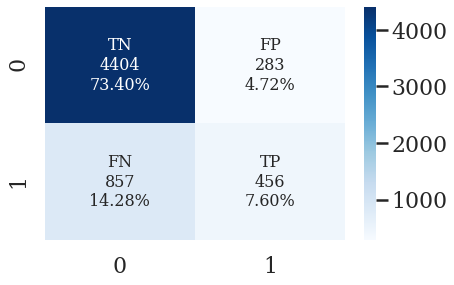

In [101]:
rfc3 = RandomForestClassifier().fit(X_tr3, y_tr)
y_pred_rfc_tr3 = rfc3.predict(X_tr3)
y_pred_rfc_val3 = rfc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_rfc_tr3, y_pred_rfc_val3, rfc3)

Training Accuracy:  0.9981904761904762
Validation Accuracy:  0.7188333333333333
Training F1 Score:  0.9959086993970714
Validation F1 Score:  0.37541651240281376
Training AUC Score:  0.9999897631548847
Validation AUC Score:  0.5992100137292127
Training Recall Score:  0.9933419243986255
Validation Recall Score:  0.38613861386138615
Training Precision Score:  0.9984887737478411
Validation Precision Score:  0.36527377521613835
Training Average Precision Score:  0.9999475524955731
Validation Average Precision Score:  0.27535180380731306

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      0.99      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

          

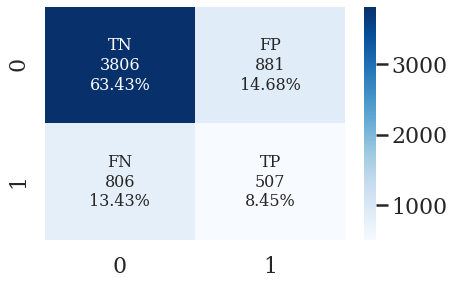

In [103]:
dtc3 = DecisionTreeClassifier().fit(X_tr3, y_tr)
y_pred_dtc_tr3 = dtc3.predict(X_tr3)
y_pred_dtc_val3 = dtc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_dtc_tr3, y_pred_dtc_val3, dtc3)

Training Accuracy:  0.8203333333333334
Validation Accuracy:  0.8166666666666667
Training F1 Score:  0.4539007092198582
Validation F1 Score:  0.4270833333333333
Training AUC Score:  0.7885068784765851
Validation AUC Score:  0.7698016145840019
Training Recall Score:  0.33676975945017185
Validation Recall Score:  0.31226199543031224
Training Precision Score:  0.6959609409675988
Validation Precision Score:  0.6754530477759473
Training Average Precision Score:  0.5541931238157705
Validation Average Precision Score:  0.5141259975421107

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.70      0.34      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.67     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

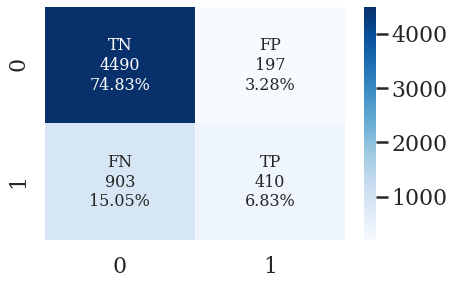

In [106]:
abc3 = AdaBoostClassifier().fit(X_tr3, y_tr)
y_pred_abc_tr3 = abc3.predict(X_tr3)
y_pred_abc_val3 = abc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_abc_tr3, y_pred_abc_val3, abc3)

Training Accuracy:  0.8293809523809523
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.505861260515791
Validation F1 Score:  0.46488625123639954
Training AUC Score:  0.8086372664474957
Validation AUC Score:  0.7798378818696234
Training Recall Score:  0.39390034364261167
Validation Recall Score:  0.357958872810358
Training Precision Score:  0.7067437379576108
Validation Precision Score:  0.6629055007052186
Training Average Precision Score:  0.6093892297416628
Validation Average Precision Score:  0.540607481244982

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.51      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

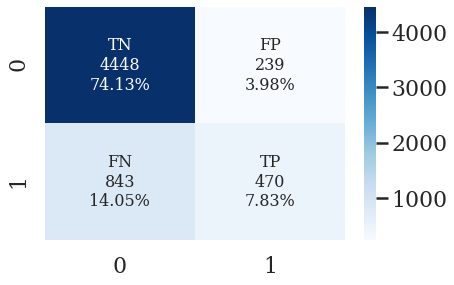

In [104]:
gbc3 = GradientBoostingClassifier().fit(X_tr3, y_tr)
y_pred_gbc_tr3 = gbc3.predict(X_tr3)
y_pred_gbc_val3 = gbc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gbc_tr3, y_pred_gbc_val3, gbc3)

[20:47:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.8934761904761904
Validation Accuracy:  0.8145
Training F1 Score:  0.7090648979060996
Validation F1 Score:  0.4604944255937954
Training AUC Score:  0.9491279390652516
Validation AUC Score:  0.7567165326271512
Training Recall Score:  0.5854810996563574
Validation Recall Score:  0.3617669459253618
Training Precision Score:  0.8987800857237059
Validation Precision Score:  0.6333333333333333
Training Average Precision Score:  0.8667933250727343
Validation Average Precision Score:  0.5164785907668311

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16344
           1       0.90 

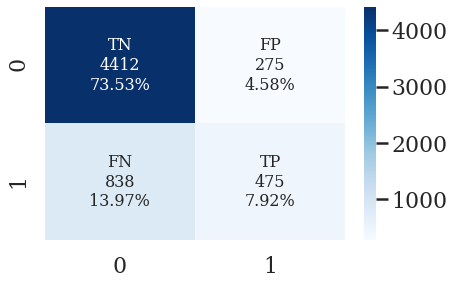

In [107]:
xgb3 = XGBClassifier().fit(X_tr3, y_tr)
y_pred_xgb_tr3 = xgb3.predict(X_tr3)
y_pred_xgb_val3 = xgb3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_xgb_tr3, y_pred_xgb_val3, xgb3)

In [108]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val3), 
                     accuracy(y_val, y_pred_rfc_val3), 
                     accuracy(y_val, y_pred_dtc_val3), 
                     accuracy(y_val, y_pred_abc_val3), 
                     accuracy(y_val, y_pred_gbc_val3),
                     accuracy(y_val, y_pred_xgb_val3)],
        'F1 Score': [f1(y_val, y_pred_log_val3), 
                     f1(y_val, y_pred_rfc_val3), 
                     f1(y_val, y_pred_dtc_val3), 
                     f1(y_val, y_pred_abc_val3), 
                     f1(y_val, y_pred_gbc_val3),
                     f1(y_val, y_pred_xgb_val3)],
        'ROC AUC': [auc(X_val3, y_val, logreg3),
                    auc(X_val3, y_val, rfc3),
                    auc(X_val3, y_val, dtc3),
                    auc(X_val3, y_val, abc3),
                    auc(X_val3, y_val, gbc3),
                    auc(X_val3, y_val, xgb3)],
        'Recall': [recall(y_val, y_pred_log_val3), 
                   recall(y_val, y_pred_rfc_val3), 
                   recall(y_val, y_pred_dtc_val3), 
                   recall(y_val, y_pred_abc_val3),
                   recall(y_val, y_pred_gbc_val3),
                   recall(y_val, y_pred_xgb_val3)],
        'Precision': [precision(y_val, y_pred_log_val3), 
                      precision(y_val, y_pred_rfc_val3), 
                      precision(y_val, y_pred_dtc_val3), 
                      precision(y_val, y_pred_abc_val3),
                      precision(y_val, y_pred_gbc_val3),
                      precision(y_val, y_pred_xgb_val3)],
        'PR AUC': [aps(X_val3, y_val, logreg3),
                   aps(X_val3, y_val, rfc3),
                   aps(X_val3, y_val, dtc3),
                   aps(X_val3, y_val, abc3),
                   aps(X_val3, y_val, gbc3),
                   aps(X_val3, y_val, xgb3)]}
new_baseline = pd.DataFrame(data=data, index = ['Logistic Regression 3', 
                                          'Random Forest Classifier 3', 
                                          'Decision Tree Classifier 3', 
                                          'AdaBoost Classifier 3', 
                                          'Gradient Boosting Classifier 3',
                                          'XGBoost Classifier 3'])

In [109]:
new_baseline

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression 3,0.816833,0.439572,0.749098,0.328256,0.665123,0.499907
Random Forest Classifier 3,0.810000,0.444444,0.750942,0.347296,0.617050,0.496650
Decision Tree Classifier 3,0.718833,0.375417,0.599210,0.386139,0.365274,0.275352
AdaBoost Classifier 3,0.816667,0.427083,0.769802,0.312262,0.675453,0.514126
Gradient Boosting Classifier 3,0.819667,0.464886,0.779838,0.357959,0.662906,0.540607
XGBoost Classifier 3,0.814500,0.460494,0.756717,0.361767,0.633333,0.516479
